# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44110 instead
  http_address["port"], self.http_server.port


In [10]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:33843 Dashboard: http://10.12.205.30/proxy/44110/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [11]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'
        if yr>2009:
            yy = '.20100101-20141231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff

In [12]:
'''component = 'land'
ee = 0
model = 'CESM2'
field = 'RAIN'
yr = 2010

topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
mm = mlist[ee]
atm    = '/atm/proc/tseries/day_1/'
lnd    = '/lnd/proc/tseries/day_1/'
firstyear = 10*int(yr/10)
yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
if yr>2009:
    yy = '.20100101-20141231.'

print(mm)
print(lnd)
print(field)
print(yy)
print(mm+lnd+'*.h5.'+field+yy+'*')
if component == 'land': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
print(ff)'''

"component = 'land'\nee = 0\nmodel = 'CESM2'\nfield = 'RAIN'\nyr = 2010\n\ntopdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'\nmlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data\nmm = mlist[ee]\natm    = '/atm/proc/tseries/day_1/'\nlnd    = '/lnd/proc/tseries/day_1/'\nfirstyear = 10*int(yr/10)\nyy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'\nif yr>2009:\n    yy = '.20100101-20141231.'\n\nprint(mm)\nprint(lnd)\nprint(field)\nprint(yy)\nprint(mm+lnd+'*.h5.'+field+yy+'*')\nif component == 'land': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]\nif component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]\nprint(ff)"

In [13]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [14]:
def get_daily(model,fields,firstyear, component,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [15]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [16]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [17]:
%%time

lnd_vars = ['RAIN','SNOW']
model = 'CESM2'
firstyear = 1980
component = 'lnd'
nens = 4  # read in 10 ensemble members for now
ds = get_daily(model,lnd_vars,firstyear, component,nens)
#print(ds)

atm_vars = ['TREFHT','RHREFHT']
component = 'atm'
ds_atm = get_daily(model,atm_vars,firstyear, component,nens)

#ds_atm['TREFHT','RHREFHT']

CPU times: user 3.25 s, sys: 290 ms, total: 3.54 s
Wall time: 8 s


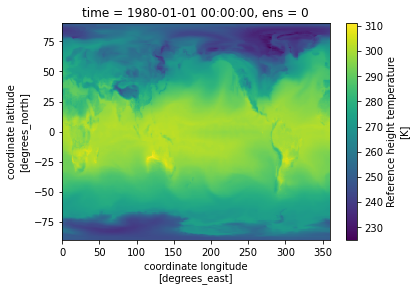

In [18]:
#force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']
ds[atm_vars[0]] = ds_atm[atm_vars[0]]
ds[atm_vars[1]] = ds_atm[atm_vars[1]]
ds[atm_vars[0]].isel(ens=0,time=0).plot();   

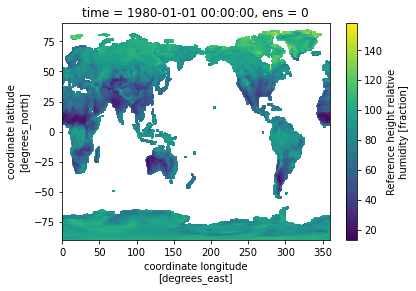

In [19]:
# sum rain + snow for precip.
ds['PPT'] = ds['RAIN']+ds['SNOW']
ds.PPT.attrs['units'] = ds.RAIN.attrs['units']
ds.PPT.attrs['long_name'] = 'Total Precip.'

# mask out oceans for temp and RH
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)
ds['RHREFHT'].isel(time=0,ens=0).plot();

In [20]:
# for speed, lets just look a single grid cell
#ds = ds.sel(lat=-25,lon=125, method='nearest').load()

### Calculate Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


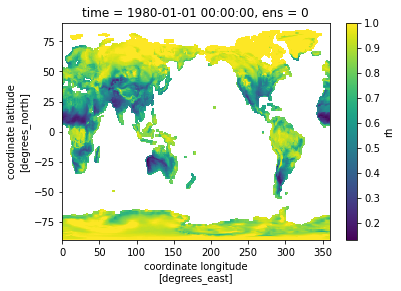

In [21]:
# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62 
fdi_b = 243.12
ds['temp'] = ds['TREFHT'] - 273.15 #convert to degC
ds['rh'] = ds['RHREFHT']/100 # convert to fraction
ds['rh'] = ds['rh'].where(ds.rh<1,1) # set max rh=1
# mask out missing values (again)
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)

ds.rh.isel(time=0,ens=0).plot();

In [22]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?  
yipsolon = (fdi_a* ds.temp)/(fdi_b+ ds.temp)+np.log(ds.rh)#.compute(skipna=True) 

#Standard met. formula
dewpoint = (fdi_b*yipsolon)/(fdi_a-yipsolon)#.compute(skipna=True)   

#follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = ((ds.temp-dewpoint)* ds.temp)#.compute(skipna=True) 
# rest d_NI when PPT >3 mm/day
s2d = 3600*24
# don't allow negative values
ds['d_NI'] = ds['d_NI'].where(ds['d_NI']>0,0)  

# Accumulate Nesterov index over the fire season, but reset when daily precip > 3 mm/day. '
# set d_NI to nan when PPT>3 mm /day
ds['d_NI'] = ds['d_NI'].where((ds.PPT*s2d)<3,np.nan)

# plot gridded data
#ds['d_NI'].isel(ens=0,time=150).plot()

KilledWorker: ("('where-getitem-415474e92e89e32017aa633cbe652733', 0, 0)", <Worker 'tcp://10.12.205.31:39889', name: 0-27, memory: 0, processing: 1>)

In [27]:
%%time 
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work, 
#    not so much for the numpy example...

# select single grid cell
for i in range(nens):
    #v = pd.Series(ds['d_NI'].isel(ens=i).values)
    v = pd.Series(ds['d_NI'].sel(lat=-25,lon=125, method='nearest').isel(ens=i).values)
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()

    plt.plot(result)

plt.ylabel('acc_NI');

KilledWorker: ("('where-getitem-3c54f5a66238a5f2c300379b4ba6d048', 2)", <Worker 'tcp://10.12.205.31:42383', name: 0-30, memory: 0, processing: 1>)

How does this get built out efficiently?

In [ ]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.plot(v)
plt.ylabel('d_NI')
plt.subplot(1,2,2)
plt.plot(result)
plt.ylabel('acc_NI');

In [ ]:
print(ds.time['time'])

In [25]:
ds['d_NI'].isel(time=0,ens=0).plot()

KilledWorker: ("('where-getitem-6badac1209ef9884dd3066bfb93a482b', 0, 0)", <Worker 'tcp://10.12.205.31:43743', name: 0-9, memory: 0, processing: 1>)